<a href="https://colab.research.google.com/github/sergiobm3/ESI_MachineLearning/blob/NLP/TFIDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> We are the SSJ team and this is our work about natural language processing.

---

In [69]:
import io
import pandas as pd
from google.colab import files
import re
import numpy as np

from ast import literal_eval
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression, mutual_info_classif
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


## 0. Loading Data

We start by loading the data file that contains the preprocessing tweets with which the study will work. The file format to upload is CSV.

For this purpose, we use some commands provided by Google Colab itself to access files on our computer.

In [70]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),sep=',')
  
with_e = []
without_e = []
for i in range(0,len(df)):
  without_e.append(literal_eval(df.iloc[i]['preprocessing_without_emoticons']))
  with_e.append(literal_eval(df.iloc[i]['preprocessing_with_emoticons']))

df['preprocessing_without_emoticons'] = without_e
df['preprocessing_with_emoticons'] = with_e
df = df.drop(columns=['Unnamed: 0'])
df

Saving prepocessed_data.csv to prepocessed_data (2).csv
User uploaded file "prepocessed_data.csv" with length 3626745 bytes


,preprocessing_without_emoticons,preprocessing_with_emoticons,class
0,"[woman, complain, cleaning, house, man, always...","[woman, complain, cleaning, house, man, always...",2
1,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...","[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",1
2,"[dawg, ever, fuck, bitch, start, cry, confused...","[dawg, !, !, !, ever, fuck, bitch, start, cry,...",1
3,"[look, like, tranny]","[look, like, tranny]",1
4,"[shit, hear, might, true, might, faker, bitch,...","[shit, hear, might, true, might, faker, bitch,...",1
...,...,...,...
24778,"[yous, muthaf, lie, right, TL, trash, mine, bi...","[yous, muthaf, lie, right, !, TL, trash, mine,...",1
24779,"[gone, broke, wrong, heart, baby, drove, redne...","[gone, broke, wrong, heart, baby, drove, redne...",2
24780,"[young, buck, wanna, eat, dat, nigguh, like, a...","[young, buck, wanna, eat, !, !, dat, nigguh, l...",1
24781,"[youu, got, wild, bitch, tellin, lie]","[youu, got, wild, bitch, tellin, lie]",1


# 2. Vectorization

When the tweets are preprocessed, we can start to obtain information from them.

The goal of this section is to obtain a dataframe with all the information which will be used for the next one, in order to classify the tweets.


## TFIDF

In order to start using TFIDF, we will first have to create a TFIDFVectorizer.

With Tfidfvectorizer you compute the word counts, idf and tf-idf values all at once. Three steps at once

In [71]:
def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer,min_df=1,lowercase=False)

X = vectorizer.fit_transform(df['preprocessing_with_emoticons'])

# 3. Select features

We have created a new dataset where we have put the characteristics with which we will work from now on. With this dataset, feature selection will be made.

To carry out the selection of characteristics, the selectKBest function will be used. You will have to pass it the number of "top" characteristics that it will choose from the existing ones. As each column is a different word and in our problem we are asked to eliminate 70% of the words, we will only have 30% of our vocabulary.

In [73]:
# Create features and target variable for Classification problem
X_clf = X

y_clf = df['class'] # Target variable: class

n_k = round(X.shape[1] * 0.3)

best=SelectKBest(score_func = mutual_info_classif, k = n_k)
X_new = best.fit_transform(X_clf, y_clf)
print(X_new.shape)

selected = best.get_support(indices=True)
selected

(24783, 5599)


array([    0,     1,     2, ..., 18655, 18660, 18661])

# 4. Classification algorithm

## Single Validation

Once we know the three characteristics with which we are going to work, it is time to separate the dataset records in the training part and the test part. The test part will be made up of 30% of the tweets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_clf, test_size=0.3 random_state=0)

## Model Execution



In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### K-nearest neighbors algorithm

With this algorithm we are going to classify the tweets depending on the tweets closest to the one to be predicted.

In [102]:
# Number of closest tweets that you will consult.
n_neighbors = 3
weights = 'distance'
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
# Fit and predict
knn.fit(X = X_train, y = y_train)
y_pred = knn.predict(X = X_test.toarray())
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8425016812373907


Finally, we obtain the Confusion Matrix

**Confusion Matrix**

Normalized confusion matrix
[[0.06546275 0.76297968 0.17155756]
 [0.00400557 0.95193312 0.0440613 ]
 [0.0032     0.3816     0.6152    ]]


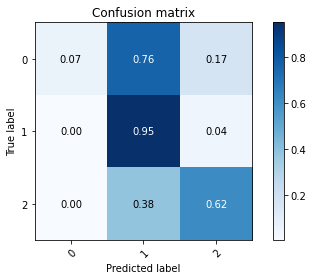

In [103]:
target_name=np.array(['0', '1', '2'], dtype='<U10')
plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title='Confusion matrix')
  

**Classification Report**

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.07      0.12       443
           1       0.87      0.95      0.91      5742
           2       0.70      0.62      0.66      1250

    accuracy                           0.84      7435
   macro avg       0.70      0.54      0.56      7435
weighted avg       0.82      0.84      0.82      7435



### Naive Bayes algorithm

This algorithm is based on Bayes' Theorem. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature.

In [99]:
#GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
clf = ComplementNB() # Classifier chosen
clf.fit(X_train.toarray(), y_train)
y_pred = clf.predict(X_test.toarray())
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.8610625420309348


**Confusion Matrix**

Normalized confusion matrix
[[0.36568849 0.49887133 0.13544018]
 [0.02647161 0.9137931  0.05973528]
 [0.036      0.1696     0.7944    ]]


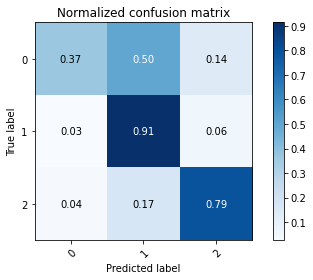

In [100]:
plot_confusion_matrix(y_test, y_pred , classes = unique_labels(y_test, y_pred), normalize=True,
                      title='Normalized confusion matrix')

**Classification Report**

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.37      0.40       443
           1       0.92      0.91      0.92      5742
           2       0.71      0.79      0.75      1250

    accuracy                           0.86      7435
   macro avg       0.70      0.69      0.69      7435
weighted avg       0.86      0.86      0.86      7435



### Cross validation.

TRAIN[ 0 ]: [24291  3078 16565 ...  9845 10799  2732] TEST[ 0 ]: [ 4129 15081 16547 ...  1603   290  6383]
Acc 0.800941492938803
Normalized confusion matrix
[[0.11241218 0.83138173 0.05620609]
 [0.01705238 0.96485123 0.0180964 ]
 [0.20935765 0.5035686  0.28707375]]
              precision    recall  f1-score   support

           0       0.12      0.11      0.11       427
           1       0.85      0.96      0.90      5747
           2       0.74      0.29      0.41      1261

    accuracy                           0.80      7435
   macro avg       0.57      0.45      0.48      7435
weighted avg       0.79      0.80      0.77      7435

TRAIN[ 1 ]: [17033  1936  9470 ...  3181   557  8693] TEST[ 1 ]: [19665 21122 17271 ... 23243 12832  6186]
Acc 0.7991930060524546
Normalized confusion matrix
[[0.04634146 0.90243902 0.05121951]
 [0.00260507 0.98228552 0.01510941]
 [0.00157853 0.78768745 0.21073402]]
              precision    recall  f1-score   support

           0       0.53      0.

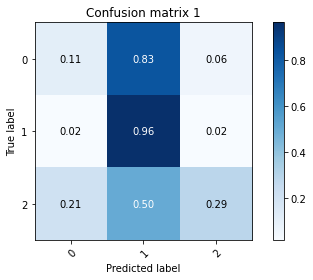

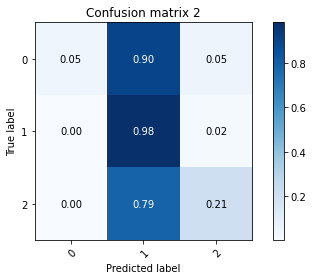

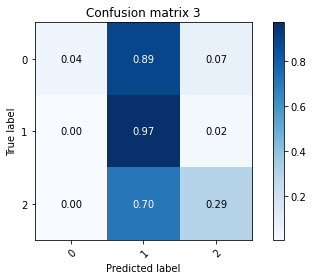

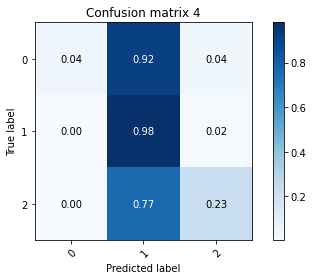

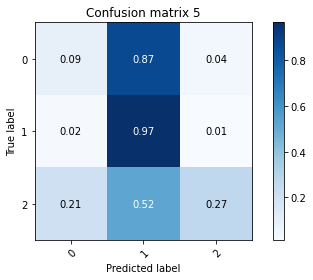

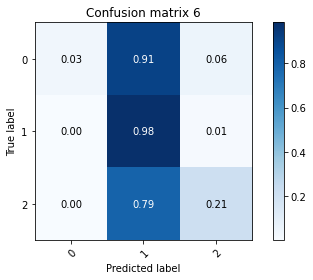

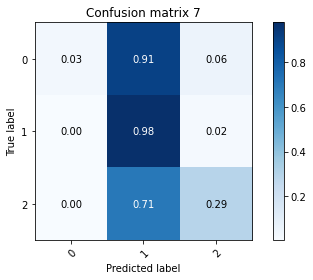

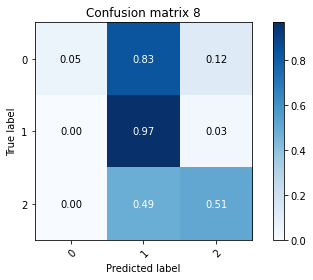

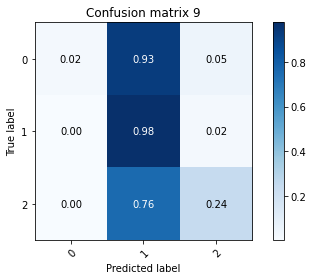

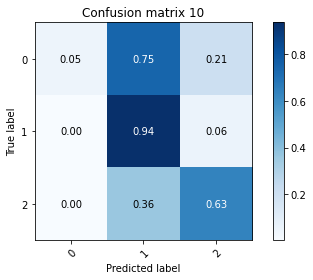

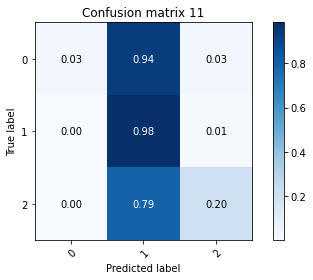

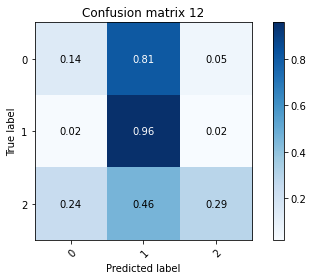

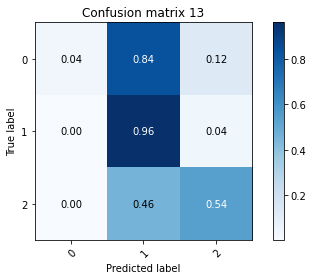

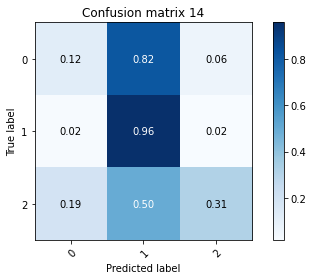

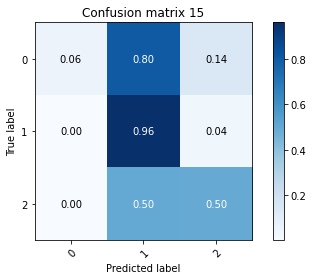

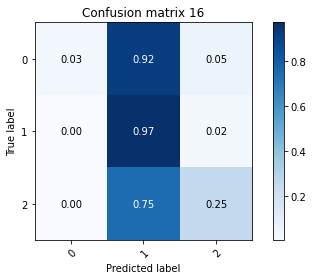

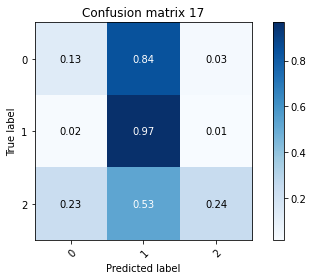

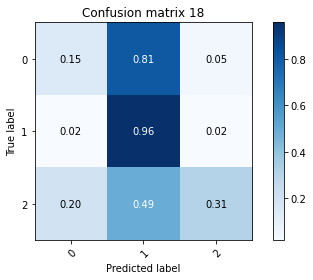

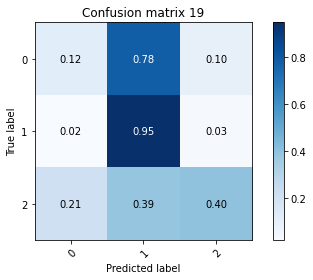

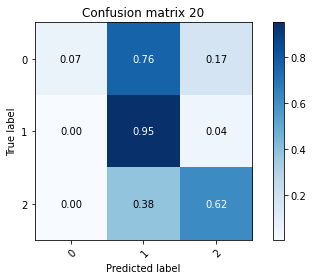

In [105]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=20, test_size=.3, random_state=0, train_size=0.7)

# Number of closest tweets that you will consult.
n_neighbors = 3
weights = 'distance'
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
cont = 0;
for train_index, test_index in rs.split(X_new):
  rs.get_n_splits()
  print("TRAIN[",cont,"]:", train_index, "TEST[",cont,"]:", test_index)
  X_train, X_test = X_new[train_index], X_new[test_index]
  y_train, y_test = y_clf[train_index], y_clf[test_index]
  # Fit and predict
  knn.fit(X = X_train, y = y_train)
  y_pred = knn.predict(X = X_test.toarray())
  acc = accuracy_score(y_test, y_pred)
  print ('Acc', acc)
  cont = cont +1
  title = 'Confusion matrix ' + str(cont)
  plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title=title)
  print(classification_report(y_test, y_pred))

TRAIN[ 0 ]: [24291  3078 16565 ...  9845 10799  2732] TEST[ 0 ]: [ 4129 15081 16547 ...  1603   290  6383]
Acc 0.8564895763281776
Normalized confusion matrix
[[0.39344262 0.46838407 0.1381733 ]
 [0.02836262 0.90882199 0.06281538]
 [0.03885805 0.18636003 0.77478192]]
              precision    recall  f1-score   support

           0       0.44      0.39      0.42       427
           1       0.92      0.91      0.92      5747
           2       0.70      0.77      0.74      1261

    accuracy                           0.86      7435
   macro avg       0.69      0.69      0.69      7435
weighted avg       0.86      0.86      0.86      7435

TRAIN[ 1 ]: [17033  1936  9470 ...  3181   557  8693] TEST[ 1 ]: [19665 21122 17271 ... 23243 12832  6186]
Acc 0.8516476126429052
Normalized confusion matrix
[[0.35121951 0.46585366 0.18292683]
 [0.03178187 0.89805488 0.07016325]
 [0.03630624 0.16101026 0.8026835 ]]
              precision    recall  f1-score   support

           0       0.39      0

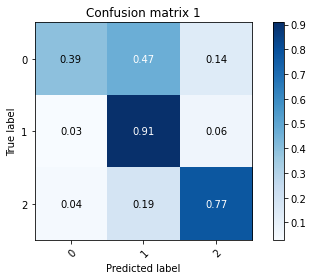

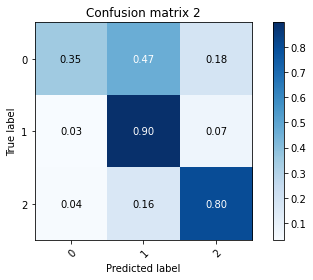

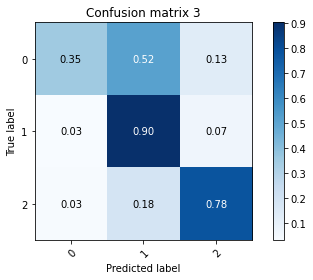

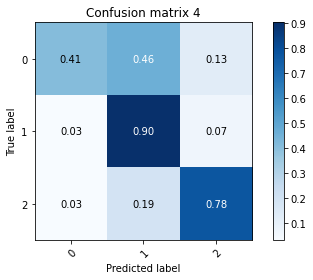

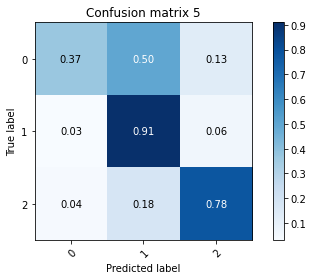

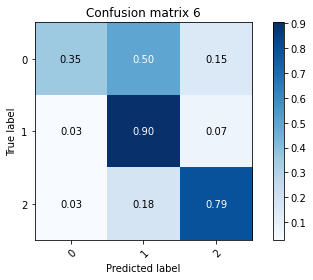

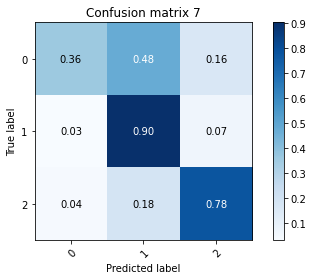

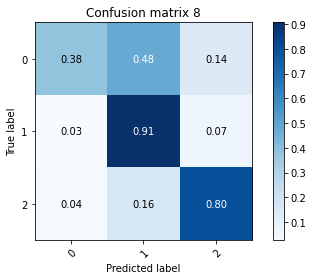

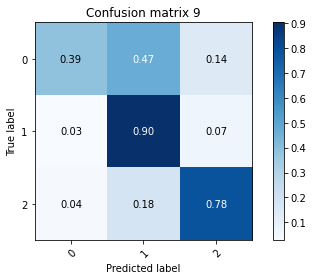

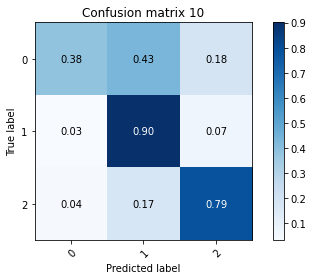

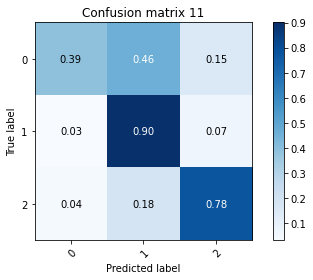

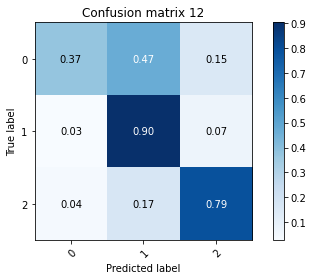

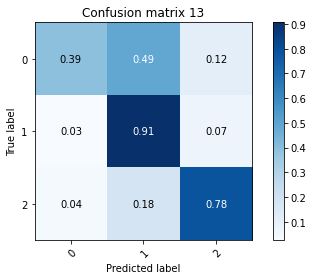

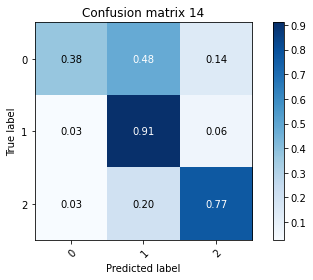

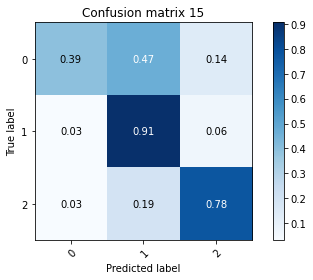

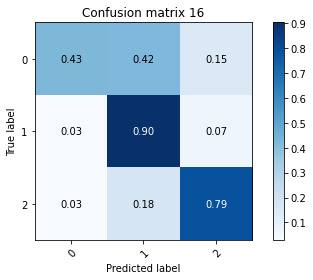

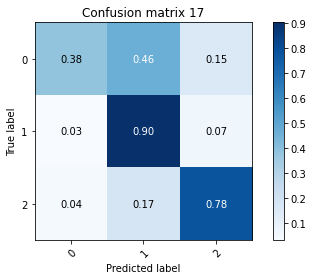

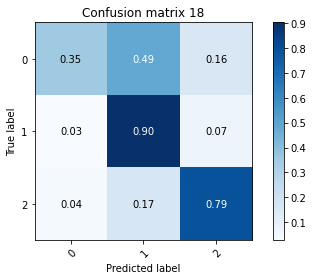

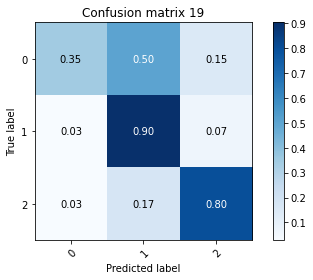

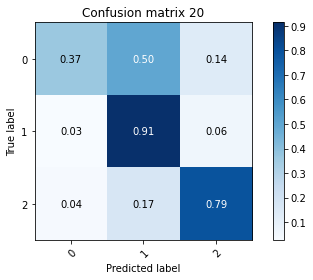

In [106]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ShuffleSplit

rs = ShuffleSplit(n_splits=20, test_size=.3, random_state=0, train_size=0.7)

# Number of closest tweets that you will consult.
n_neighbors = 3
weights = 'distance'
knn = KNeighborsClassifier(n_neighbors= n_neighbors, weights=weights) 
cont = 0;
for train_index, test_index in rs.split(X_new):
  rs.get_n_splits()
  print("TRAIN[",cont,"]:", train_index, "TEST[",cont,"]:", test_index)
  X_train, X_test = X_new[train_index], X_new[test_index]
  y_train, y_test = y_clf[train_index], y_clf[test_index]
  # Fit and predict
  #GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
  clf = ComplementNB() # Classifier chosen
  clf.fit(X_train.toarray(), y_train)
  y_pred = clf.predict(X_test.toarray())
  acc = accuracy_score(y_test, y_pred)
  print ('Acc', acc)
  cont = cont +1
  title = 'Confusion matrix ' + str(cont)
  plot_confusion_matrix(y_test, y_pred, classes=target_name, normalize=True,
                      title=title)
  print(classification_report(y_test, y_pred))

Once we have identified the best parameterization we will go on to make an execution of the model and we will graph its results.